c:\Users\20223847\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\20223847\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


✅ Magnitude and phase plot ready!


c:\Users\20223847\AppData\Local\anaconda3\Lib\site-packages\skrf\vectorFitting.py:1291: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i, j] = self.proportional_coeff[i_response]
C:\Users\20223847\AppData\Local\Temp\ipykernel_13968\3754253470.py:84: UserWarning: Passivity enforcement: The dc point in the model is not passive. Cannot preserve the dc point during passivity enforcement. 
  vf.passivity_enforce()  # optional
C:\Users\20223847\AppData\Local\Temp\ipykernel_13968\3754253470.py:84: UserWarning: Passivity enforcement: The passivity violations of this model are unbounded. Passivity enforcement might still work, but consider re-fitting with a lower number of poles and/or without the constants (`fit_constant=False`) if the results are not satisfactory.
  vf.passivity_enforce()  # optional
C:\Users\20223847\AppData\Local\Temp\ipykernel_13968\3754253470.py:84: RuntimeWarning: Passivity enforcement: Aborting after the max. number of iterations has been

Poles: [-0.45346243+1454.65032156j -0.08321938+1452.85538321j
 -0.0922701 +1094.06954094j -0.36716199+1087.47431409j
 -0.0056799 +1092.40290435j -0.13321349+1088.73921167j
 -0.68460996+1090.75994952j -0.1067167  +721.42586293j
 -0.18338928 +730.45186313j -0.06597504 +723.01349406j
 -0.6906642  +724.08478854j -0.18902988 +725.05256708j
 -0.03694602 +729.14788111j -0.36678294 +728.70391528j
 -0.63622257 +727.07716548j]
Residues: [[ 7.07859131e+03+3.05664936e+04j -6.57110781e+03-3.30614951e+04j
   2.26674896e+06-1.18345063e+07j  1.48891935e+06-3.32222640e+06j
  -1.61875987e+07+3.30434991e+07j -2.12604505e+05+1.66197791e+07j
   1.26456532e+07-3.44907539e+07j  1.41662764e+10+3.93387278e+10j
  -5.11423633e+09+8.18031632e+09j -2.86976355e+11-2.94853113e+11j
   4.12570843e+10+9.79105452e+11j  1.45869982e+11-1.04883683e+12j
  -1.50082053e+11+1.08872250e+11j  2.16643001e+11-3.37834094e+11j
   2.42363036e+10+5.46027240e+11j]]
Constant term d: [-944.18062407]
Proportional term e: [0.+0.j]


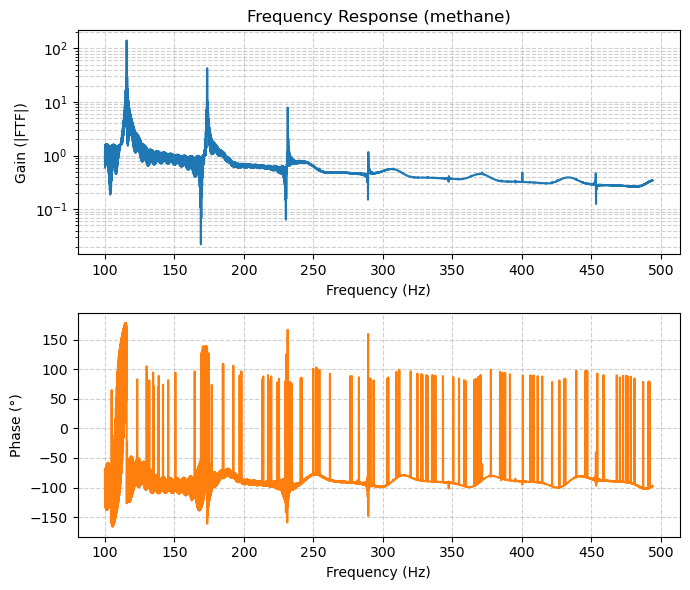

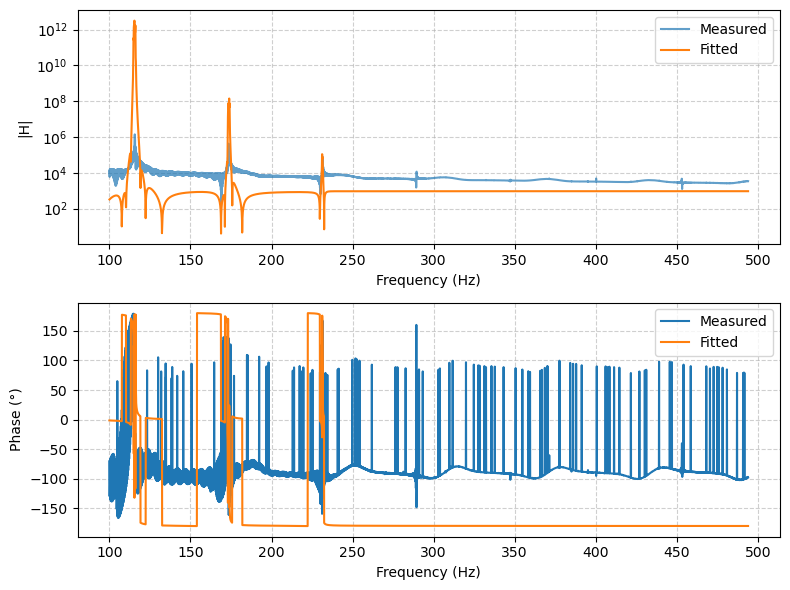

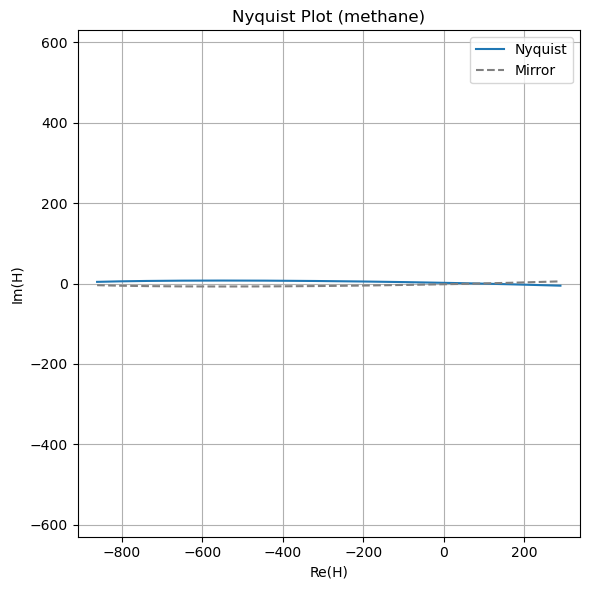

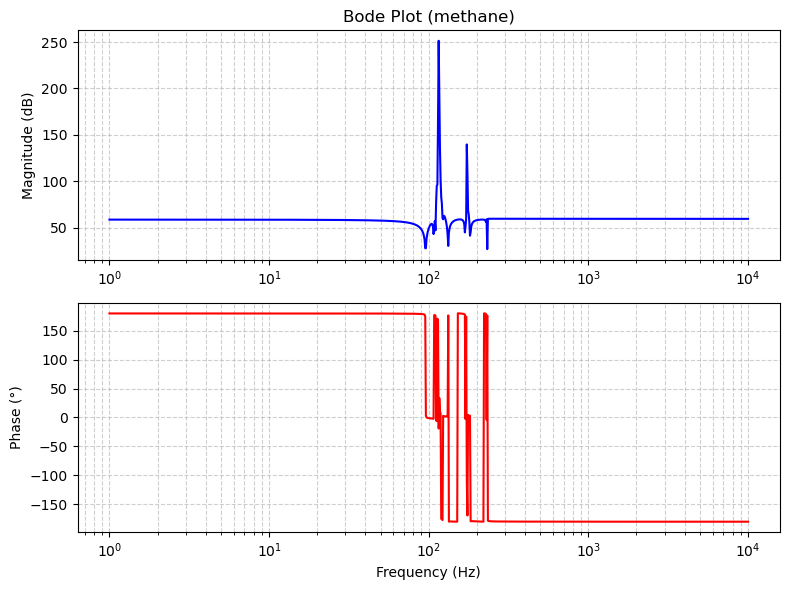

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter1d
import skrf
from skrf.vectorFitting import VectorFitting

# ----------------------------------------
# SETTINGS
# ----------------------------------------
save_path = "."
gas = "methane"
n_samples = 10000

# ----------------------------------------
# LOAD TRANSFER FUNCTION DATA
# ----------------------------------------
trans0 = np.load(f"{save_path}\\{gas}_trans.npy")

# Flattened x and y arrays for fitting
x = trans0[:, 0]
y = trans0[:, 1]

# Masks: keep all points (placeholder)
mask = y >100
mask2 = np.ones(len(trans0), dtype=bool)

x_sel = x[mask & mask2]
y_sel = y[mask & mask2]

# ----------------------------------------
# LINEAR FIT CORRECTION
# ----------------------------------------
m, b = np.polyfit(x_sel, y_sel, 1)
y_corrected = m * x_sel + b

if gas == 'methane':
    trans_corrected = trans0[mask & mask2].copy()
elif gas == 'H2':
    trans = trans0[mask & mask2].copy()
    trans_corrected = trans.copy()

# ----------------------------------------
# PLOT MAGNITUDE AND PHASE OF ORIGINAL TRANSFER FUNCTION
# ----------------------------------------
plt.figure(figsize=(7, 6))

# Magnitude plot
plt.subplot(2, 1, 1)
plt.plot(y_corrected, np.abs(trans_corrected[:, 2]) / n_samples, color='C0')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (|FTF|)")
plt.title(f"Frequency Response ({gas})")
plt.grid(True, which='both', ls='--', alpha=0.6)

# Phase plot
plt.subplot(2, 1, 2)
plt.plot(y_corrected, np.angle(trans_corrected[:, 2], deg=True), color='C1')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (°)")
plt.grid(True, which='both', ls='--', alpha=0.6)

plt.tight_layout()
print("✅ Magnitude and phase plot ready!")

# ----------------------------------------
# VECTOR FITTING
# ----------------------------------------
# Frequency and measured transfer function
f = y_corrected
H = trans_corrected[:, 2]

# Smooth magnitude using maximum filter
H_smooth = maximum_filter1d(np.abs(H), size=10) * np.exp(1j * np.angle(H))

# Create a skrf Network object
nw = skrf.Network()
nw.frequency = skrf.Frequency.from_f(f, unit='Hz')
nw.s = H_smooth.reshape(len(f), 1, 1)

# Perform vector fitting
vf = VectorFitting(nw)
vf.vector_fit(n_poles_real=20, n_poles_cmplx=5)
vf.passivity_enforce()  # optional

# Extract coefficients
poles = vf.poles
residues = vf.residues
d = vf.constant_coeff
e = vf.proportional_coeff

print("Poles:", poles)
print("Residues:", residues)
print("Constant term d:", d)
print("Proportional term e:", e)

# Evaluate fitted response
H_fit = vf.get_model_response(0, 0, f)

# ----------------------------------------
# PLOT MEASURED vs FITTED RESPONSE
# ----------------------------------------
plt.figure(figsize=(8,6))

# Magnitude
plt.subplot(2,1,1)
plt.plot(f, np.abs(H), label='Measured', alpha=0.7)
plt.plot(f, np.abs(H_fit), label='Fitted', color='C1')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("|H|")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.6)

# Phase
plt.subplot(2,1,2)
plt.plot(f, np.angle(H, deg=True), label='Measured')
plt.plot(f, np.angle(H_fit, deg=True), label='Fitted', color='C1')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (°)")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.6)

plt.tight_layout()
plt.savefig(f"{save_path}\\Fitted_ftf_{gas}.png")
plt.show()

# ----------------------------------------
# BODE AND NYQUIST PLOTS FROM VECTOR FITTING
# ----------------------------------------
# Ensure residues and poles are 1D
residues = np.array(vf.residues).flatten()
poles = np.array(vf.poles).flatten()
d = vf.constant_coeff
e = vf.proportional_coeff

def H_func(f_input):
    """Evaluate fitted transfer function from poles/residues."""
    s = 1j * 2 * np.pi * np.array(f_input, ndmin=1)
    H_out = np.zeros_like(s, dtype=complex)
    for r, p in zip(residues, poles):
        H_out += r / (s - p)  # r and p are scalars
    H_out += d + e * s
    return H_out if np.ndim(f_input) > 0 else H_out[0]


# Nyquist plot
freqs_nyquist = np.logspace(-2, 2, 1000)
H_vals_nyq = H_func(freqs_nyquist)

plt.figure(figsize=(6,6))
plt.plot(H_vals_nyq.real, H_vals_nyq.imag, label="Nyquist")
plt.plot(H_vals_nyq.real, -H_vals_nyq.imag, linestyle="--", color="gray", label="Mirror")
plt.xlabel("Re(H)")
plt.ylabel("Im(H)")
plt.title(f"Nyquist Plot ({gas})")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_path}\\nyquist_{gas}.png")
plt.show()

# Bode plot
freqs_bode = np.logspace(0, 4, 1000)
H_vals_bode = H_func(freqs_bode)
mag = 20 * np.log10(np.abs(H_vals_bode))
phase = np.angle(H_vals_bode, deg=True)

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.semilogx(freqs_bode, mag, 'b')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.ylabel("Magnitude (dB)")
plt.title(f"Bode Plot ({gas})")

plt.subplot(2,1,2)
plt.semilogx(freqs_bode, phase, 'r')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (°)")

plt.tight_layout()
plt.show()
